## Create figures

In [66]:
import pandas as pd
import os, json
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
import numpy as np
import matplotlib as mpl
from scipy import stats
from Bio import SeqIO
from pathlib import Path
import re
from datetime import datetime
import ast
import warnings
from Bio import Align
import warnings
from Bio import BiopythonParserWarning
warnings.simplefilter('ignore', BiopythonParserWarning)

CONDITIONS = ['no_template', 'template_single_seq', 'template_MSA']
RESULT_DIR = 'output'
CACHE_DIR = 'tmp'
FIGURES_DIR = 'figures'
DATA_DIR = 'data'
PROT1 = "A0A426UPE9"
PROT2 = "U1LSP8"
DOMAIN1 = "PF02369"
DOMAIN2 = "PF09534"

os.makedirs(CACHE_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

aligner = Align.PairwiseAligner()
aligner.substitution_matrix = Align.substitution_matrices.load("BLOSUM62")

# Utility functions

def collect_db_info(database_res_dir: str) -> pd.DataFrame:
    """Collect pfam and af2 databases info"""
    
    # some lines contain 2 or more proteins, fix it
    with open(os.path.join(database_res_dir, 'target_proteins.tsv'), 'r') as handle:
        text_to_fix = handle.readlines()
    fixed_text = "".join(text_to_fix).replace(' PF', '\nPF')
    with open(os.path.join(CACHE_DIR, 'target_proteins.tsv'), 'w') as handle:
        handle.write(fixed_text)

    protein_info = pd.read_table(os.path.join(CACHE_DIR, 'target_proteins.tsv'), sep=' ')
    protein_info['seq_lenght'] = [len(sequence) for sequence in protein_info.sequence]
    
    # safety check
    check = len(protein_info[protein_info.seq_end > protein_info.seq_lenght])
    assert  check == 0,\
          f"{check} proteins have upper domain boundary longer than protein lenght"
        
    
    return protein_info

def get_best_condition(df: pd.DataFrame, feature:str) -> pd.DataFrame:
    """Get condition by which the protein is the best (plddt normally). Not suitable for domain_plddt
    df: dataframe which should contain 'condition' column with {'no_template', 'template_MSA', 'template_single_seq'}
        and should contain 'uniprot_acc', 'pfamA_acc and feature
    feature: database column to use for selction. max() will be applied
    """

    condition_index = df.columns.get_loc('condition')

    outlist = []
    iter_df = df[['uniprot_acc', 'pfamA_acc']].drop_duplicates()
    for uniprot_acc, pfamA_acc in zip(iter_df.uniprot_acc.to_list(), iter_df.pfamA_acc.to_list()):
        
        # exclude case of no templates
        if len(df[(df.uniprot_acc == uniprot_acc) & (df.pfamA_acc == pfamA_acc) & (df.condition == 'template_single_seq')]) > 0 and\
            len(df[(df.uniprot_acc == uniprot_acc) & (df.pfamA_acc == pfamA_acc) & (df.condition == 'template_MSA')]) > 0:
            
            # get condition in which the structure is the best
            protein_condition = 'template_single_seq'
            if df[(df.uniprot_acc == uniprot_acc) &\
                    (df.pfamA_acc == pfamA_acc) &\
                    (df.condition == 'template_MSA')][feature].unique()[0] > \
                df[(df.uniprot_acc == uniprot_acc) &\
                    (df.pfamA_acc == pfamA_acc) &\
                    (df.condition == 'template_single_seq')][feature].unique()[0]:
                
                protein_condition = 'template_MSA'
            
            best_values = df[(df.uniprot_acc == uniprot_acc) &\
                                (df.pfamA_acc == pfamA_acc) &\
                                (df.condition == protein_condition)].values[0]
            condition = "best_pick"
            
            best_values[condition_index] = condition
            outlist.append(list(best_values))
        
    return pd.concat([df, pd.DataFrame(outlist, columns=df.columns.to_list())])

def get_log_data_wo_relaxation(logfile: str) -> pd.DataFrame():
    """Get recycle time and relaxation time from colabfold logfiles
    logfile: str: path/to/logfile.txt
    """

    logfile = open(logfile, 'r').readlines()
    
    query_p = re.compile(r"Query [0-9]{1,9}/[0-9]{1,9}: [A-Z0-9]{4,20}")
    log_time_p = re.compile(r"[0-9]{4}-[0-9]{2}-[0-9]{2} [0-9]{2}:[0-9]{2}:[0-9]{2},[0-9]{3}")
    final_time_p = re.compile(r"took [0-9]{1,5}.[0-9]s")
    recycle_p = re.compile(r"recycle=[0-9]{1,2}")
    plddt_p = re.compile(r"pLDDT=[0-9]{2}\.{0,1}[0-9]{0,2}")
    ptm_p = re.compile(r"pTM=[0-1]\.[0-9]{0,3}")
    tol_p = re.compile(r"tol=[0-9]{1,3}\.{0,1}[0-9]{0,3}")

    outlist = []
    for index, line in enumerate(logfile):
        
        if 'Query' in line:
            uniprot_acc = query_p.findall(line)[0].split()[-1]
            model = 0
        
        if 'recycle=0' in line:
            previous_timestep = log_time_p.findall(logfile[index-1])[0]
            previous_timestep = datetime.strptime(previous_timestep, '%Y-%m-%d %H:%M:%S,%f')
            timestep = log_time_p.findall(line)[0]
            timestep = datetime.strptime(timestep, '%Y-%m-%d %H:%M:%S,%f')
            delta_t = (timestep-previous_timestep).total_seconds()
            plddt = float(plddt_p.findall(line)[0].split("=")[-1])
            ptm = float(ptm_p.findall(line)[0].split("=")[-1])
            outlist.append([uniprot_acc, 0, plddt, ptm, None, delta_t, model])

        if 'alphafold2_ptm_model_' in line and 'recycle=' in line and 'recycle=0' not in line:
            previous_timestep = timestep
            timestep = log_time_p.findall(line)[0]
            timestep = datetime.strptime(timestep, '%Y-%m-%d %H:%M:%S,%f')
            delta_t = (timestep-previous_timestep).total_seconds()
            recycle = int(recycle_p.findall(line)[0].split("=")[-1])
            plddt = float(plddt_p.findall(line)[0].split("=")[-1])
            ptm = float(ptm_p.findall(line)[0].split("=")[-1])
            tol = float(tol_p.findall(line)[0].split("=")[-1])

            outlist.append([uniprot_acc, recycle, plddt, ptm, tol, delta_t, model])

        #if 'took' in line and 'Relaxation' not in line:
        #    final_time = float(final_time_p.findall(line)[0].split()[-1].replace('s', ''))
        if 'recycle=5' in line:
            model +=1
    
    return pd.DataFrame(outlist, columns = ['uniprot_acc', 'recycle', 'plddt', 'ptm', 'tol', 'delta_t', 'model'])

def get_domains_from_log(logpath: str, uniprot_acc) -> list:
    """Get tmeplate codes from logfile"""

    query_re = re.compile("Query [0-9]{0,3}/[0-9]{0,3}: " + uniprot_acc)
    templates_re = re.compile("Sequence [0-9]{0,3} found templates: ")
    found = False
    for line in open(logpath, 'r').readlines():
        if query_re.findall(line):
            found = True
        if templates_re.findall(line) and found == True:
            templates = ast.literal_eval(line.split(': ')[-1])
            return templates

def align_seqs(query:str, target:str, aligner=aligner) -> float:

    """Runs global sequence alignemnt and returns % of identity of query with target.
    Considers alignment with highest score

    param: query: query sequence
    param: target: target sequence
    aligner: Bio.Align.PairwiseAligner
    output: % of identity query-target in respect to query
    """
    aligner.mode = 'global'
    alignments = aligner.align(query, target)
    alignment = alignments[0]

    return round(alignment.counts().identities / len(query), 2)*100

In [4]:
protein_info = collect_db_info(os.path.join(RESULT_DIR, 'DB_query'))
AF2_df = pd.read_csv(os.path.join(RESULT_DIR, 'summary_results', 'AF2Results.csv'))
df_molp = pd.read_csv(os.path.join(RESULT_DIR, 'summary_results', 'molprobity_results.csv'))
df_rank = pd.read_csv(os.path.join(RESULT_DIR, 'summary_results', 'af2Rank_results.csv'))
afdb_info = pd.read_csv(os.path.join(DATA_DIR, "afdb_protein_info.csv"))
AF2_df['plddt_class'] = 'Very low'
AF2_df.loc[AF2_df.uniprot_acc.isin(AF2_df[(AF2_df.plddt > 50) & (AF2_df.condition == 'no_template')].uniprot_acc.unique()),
'plddt_class'] = 'Low'
AF2_df.loc[AF2_df.uniprot_acc.isin(AF2_df[(AF2_df.plddt > 70) & (AF2_df.condition == 'no_template')].uniprot_acc.unique()),
'plddt_class'] = 'Confident'
AF2_df.loc[AF2_df.uniprot_acc.isin(AF2_df[(AF2_df.plddt > 90) & (AF2_df.condition == 'no_template')].uniprot_acc.unique()),
'plddt_class'] = 'Very high'

In [5]:
# plot params
mpl.rcParams['font.size'] = 25
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['axes.labelsize'] = 25
mpl.rcParams['axes.labelweight'] = 'normal'
mpl.rcParams['axes.titlesize'] = 30
mpl.rcParams['axes.titleweight'] = 'normal'
# size of letters that specify images
ANNOT_FONT_SIZE = 50

## Create paper images


## Figure 1

In [62]:
# generate distributions

with open(os.path.join(DATA_DIR, 'distributions.json'), 'r') as handle:
    dist_dic = json.load(handle)
# normalize values
for pfam_id in dist_dic.keys():
    total = total = sum(dist_dic[pfam_id])
    dist_dic[pfam_id] = [dist_dic[pfam_id][i] / total for i in range(100)]

dist_df = pd.DataFrame(dist_dic).T

/nfs/research/agb/research/francesco/anaconda3/envs/danalysis2/lib/python3.12/site-packages/matplotlib/cbook.py:1699: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


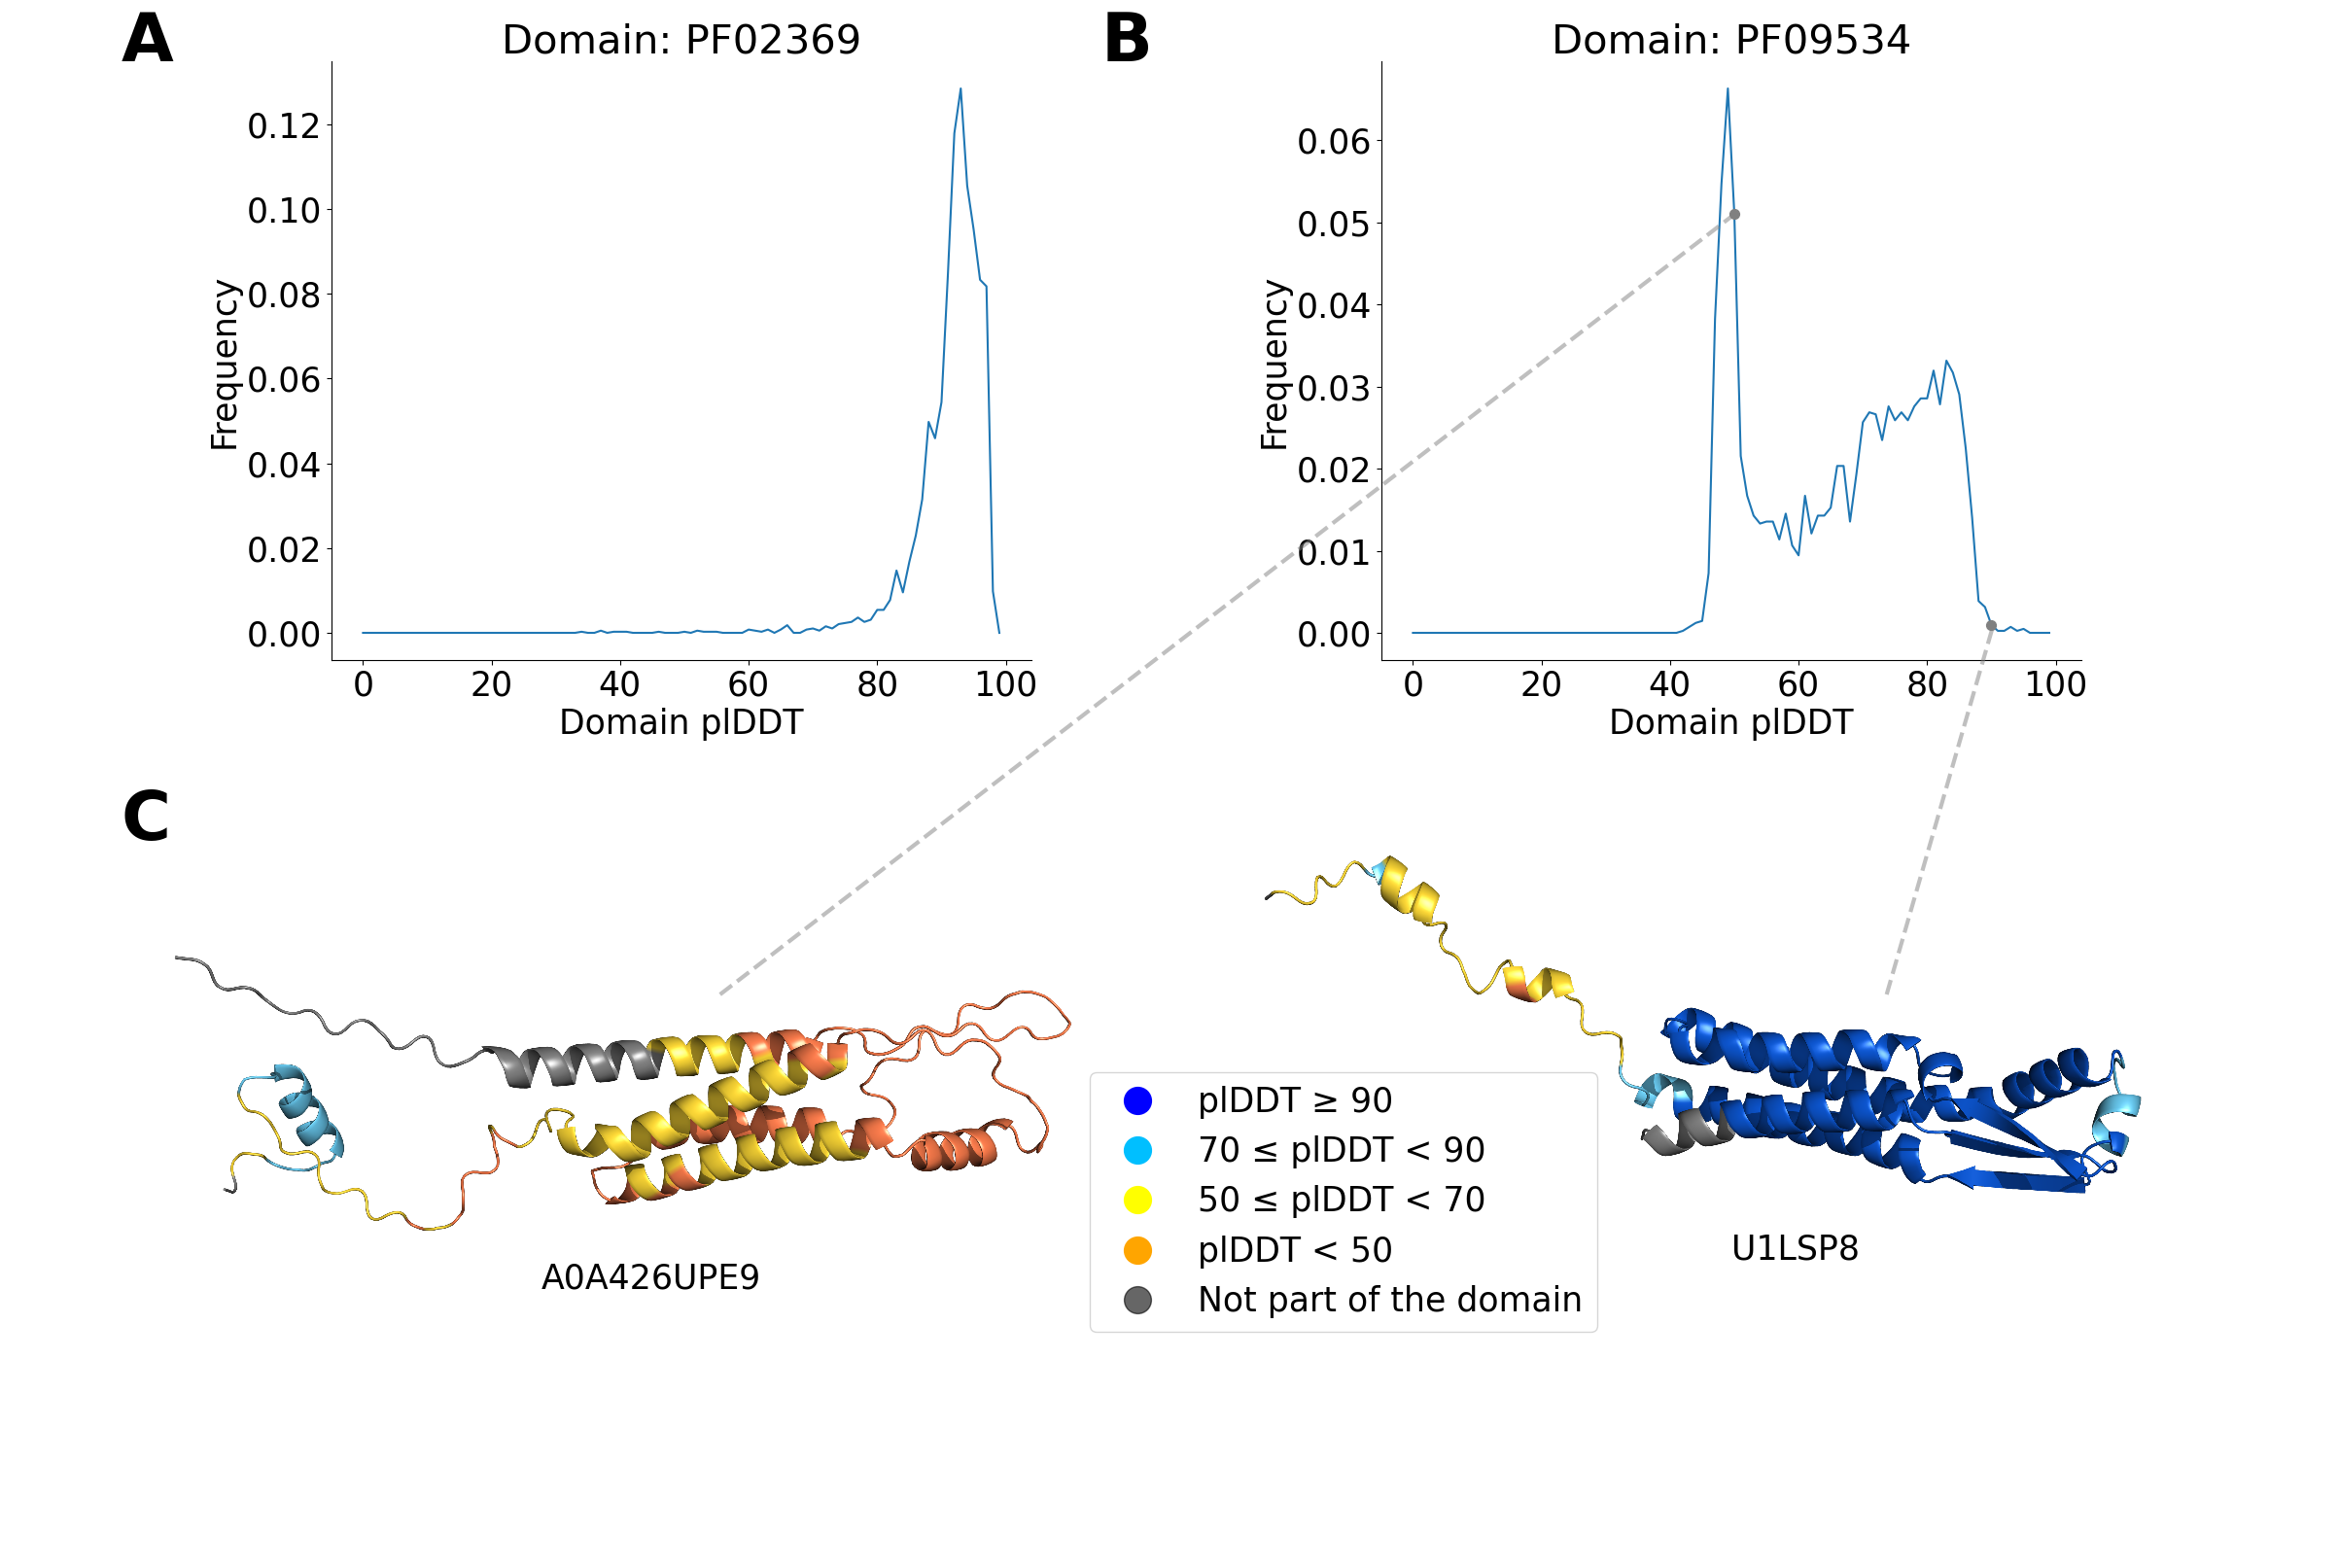

In [63]:
fig, ax = plt.subplots(2,2, figsize=[20,20])
plt.subplots_adjust(hspace=.5, 
                    wspace=.5,
                    left=0,
                    right=.9)
plt.text(-1.8,2.5, "A", weight="bold", fontsize=ANNOT_FONT_SIZE)
plt.text(-.4,2.5, "B", weight="bold", fontsize=ANNOT_FONT_SIZE)
plt.text(-1.8,1.2, "C", weight="bold", fontsize=ANNOT_FONT_SIZE)
#plt.text(-.4,1.2, "D", weight="bold", fontsize=ANNOT_FONT_SIZE)

#1
pfam_id = DOMAIN1
ax[0,0].plot(dist_df.loc[pfam_id])
ax[0,0].set_title(f"Domain: {pfam_id}")
ax[0,0].set_xlabel('Domain plDDT')
ax[0,0].set_ylabel('Frequency')
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['top'].set_visible(False)

#2
pfam_id = DOMAIN2
U1LSP8_domain_plddt = round(afdb_info[(afdb_info.alphafold_id.str.contains(PROT1)) & (afdb_info.pfam_id == pfam_id)].dom_score)
A0A426UPE9_domain_plddt = round(afdb_info[(afdb_info.alphafold_id.str.contains(PROT2)) & (afdb_info.pfam_id == pfam_id)].dom_score)

# plot distribution
ax[0,1].plot(dist_df.loc[pfam_id])
# plot domains
x = [U1LSP8_domain_plddt, A0A426UPE9_domain_plddt]
y = [dist_df.loc[pfam_id][U1LSP8_domain_plddt], dist_df.loc[pfam_id][A0A426UPE9_domain_plddt]]
ax[0,1].scatter(x, y, s=50, c='grey', zorder=2, alpha=1)
ax[0,1].set_title(f"Domain: {pfam_id}")
ax[0,1].set_xlabel('Domain plDDT')
ax[0,1].set_ylabel('Frequency')
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['top'].set_visible(False)

# add outside lines
x,y = np.array([[.2, 0.72], [.4, 0.8]])
line = Line2D(x, y, color='grey', alpha=.5, lw=3, ls="--")
fig.add_artist(line)

x,y = np.array([[.8, 0.855], [.4, 0.5905]])
line = Line2D(x, y, color='grey', alpha=.5, lw=3, ls="--")
fig.add_artist(line)

#3
ax[1,0].axis('off')
arr_img = plt.imread(os.path.join(DATA_DIR, f"{PROT1}.png"))
im = OffsetImage(arr_img, zoom=.18)
ab = AnnotationBbox(im, xy=(0, 0), xybox=(-.44, .15), box_alignment=(0, 0), bboxprops=dict(color="white"))
ax[1,0].add_artist(ab)
ax[1,0].set_zorder(-1)
ax[1,0].text(.3,.45, PROT1)

#4
ax[1,1].axis('off')
arr_img = plt.imread(os.path.join(DATA_DIR, f"{PROT2}.png"))
im = OffsetImage(arr_img, zoom=.18)
ab = AnnotationBbox(im, xy=(0, 0), xybox=(-.4, .2), box_alignment=(0, 0), bboxprops=dict(color="white"))
ax[1,1].add_artist(ab)
ax[1,1].set_zorder(-1)
ax[1,1].text(.5,.5, PROT2)

# add legend
ms = 20
handles = [
    plt.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=ms),
    plt.Line2D([], [], color='deepskyblue', marker='o', linestyle='None', markersize=ms),
    plt.Line2D([], [], color='yellow', marker='o', linestyle='None', markersize=ms),
    plt.Line2D([], [], color='orange', marker='o', linestyle='None', markersize=ms),
    plt.Line2D([], [], color='black', marker='o', linestyle='None', markersize=ms, alpha=0.6)
]
labels = ['plDDT ≥ 90', '70 ≤ plDDT < 90', '50 ≤ plDDT < 70', 'plDDT < 50', 'Not part of the domain']
legend = ax[1,1].legend(handles, labels, loc='lower left', 
                   frameon=True, facecolor=None, ncol=1, bbox_to_anchor=(-.44,.35),
                   )
legend.set_title('')

plt.savefig(os.path.join(FIGURES_DIR, 'figure1.png'), dpi=190,  transparent=False, bbox_inches='tight')

plt.show()

## Figure 2

/tmp/ipykernel_2004524/1724257013.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(ax[1,0].get_xticklabels(), ha="right", rotation=45)


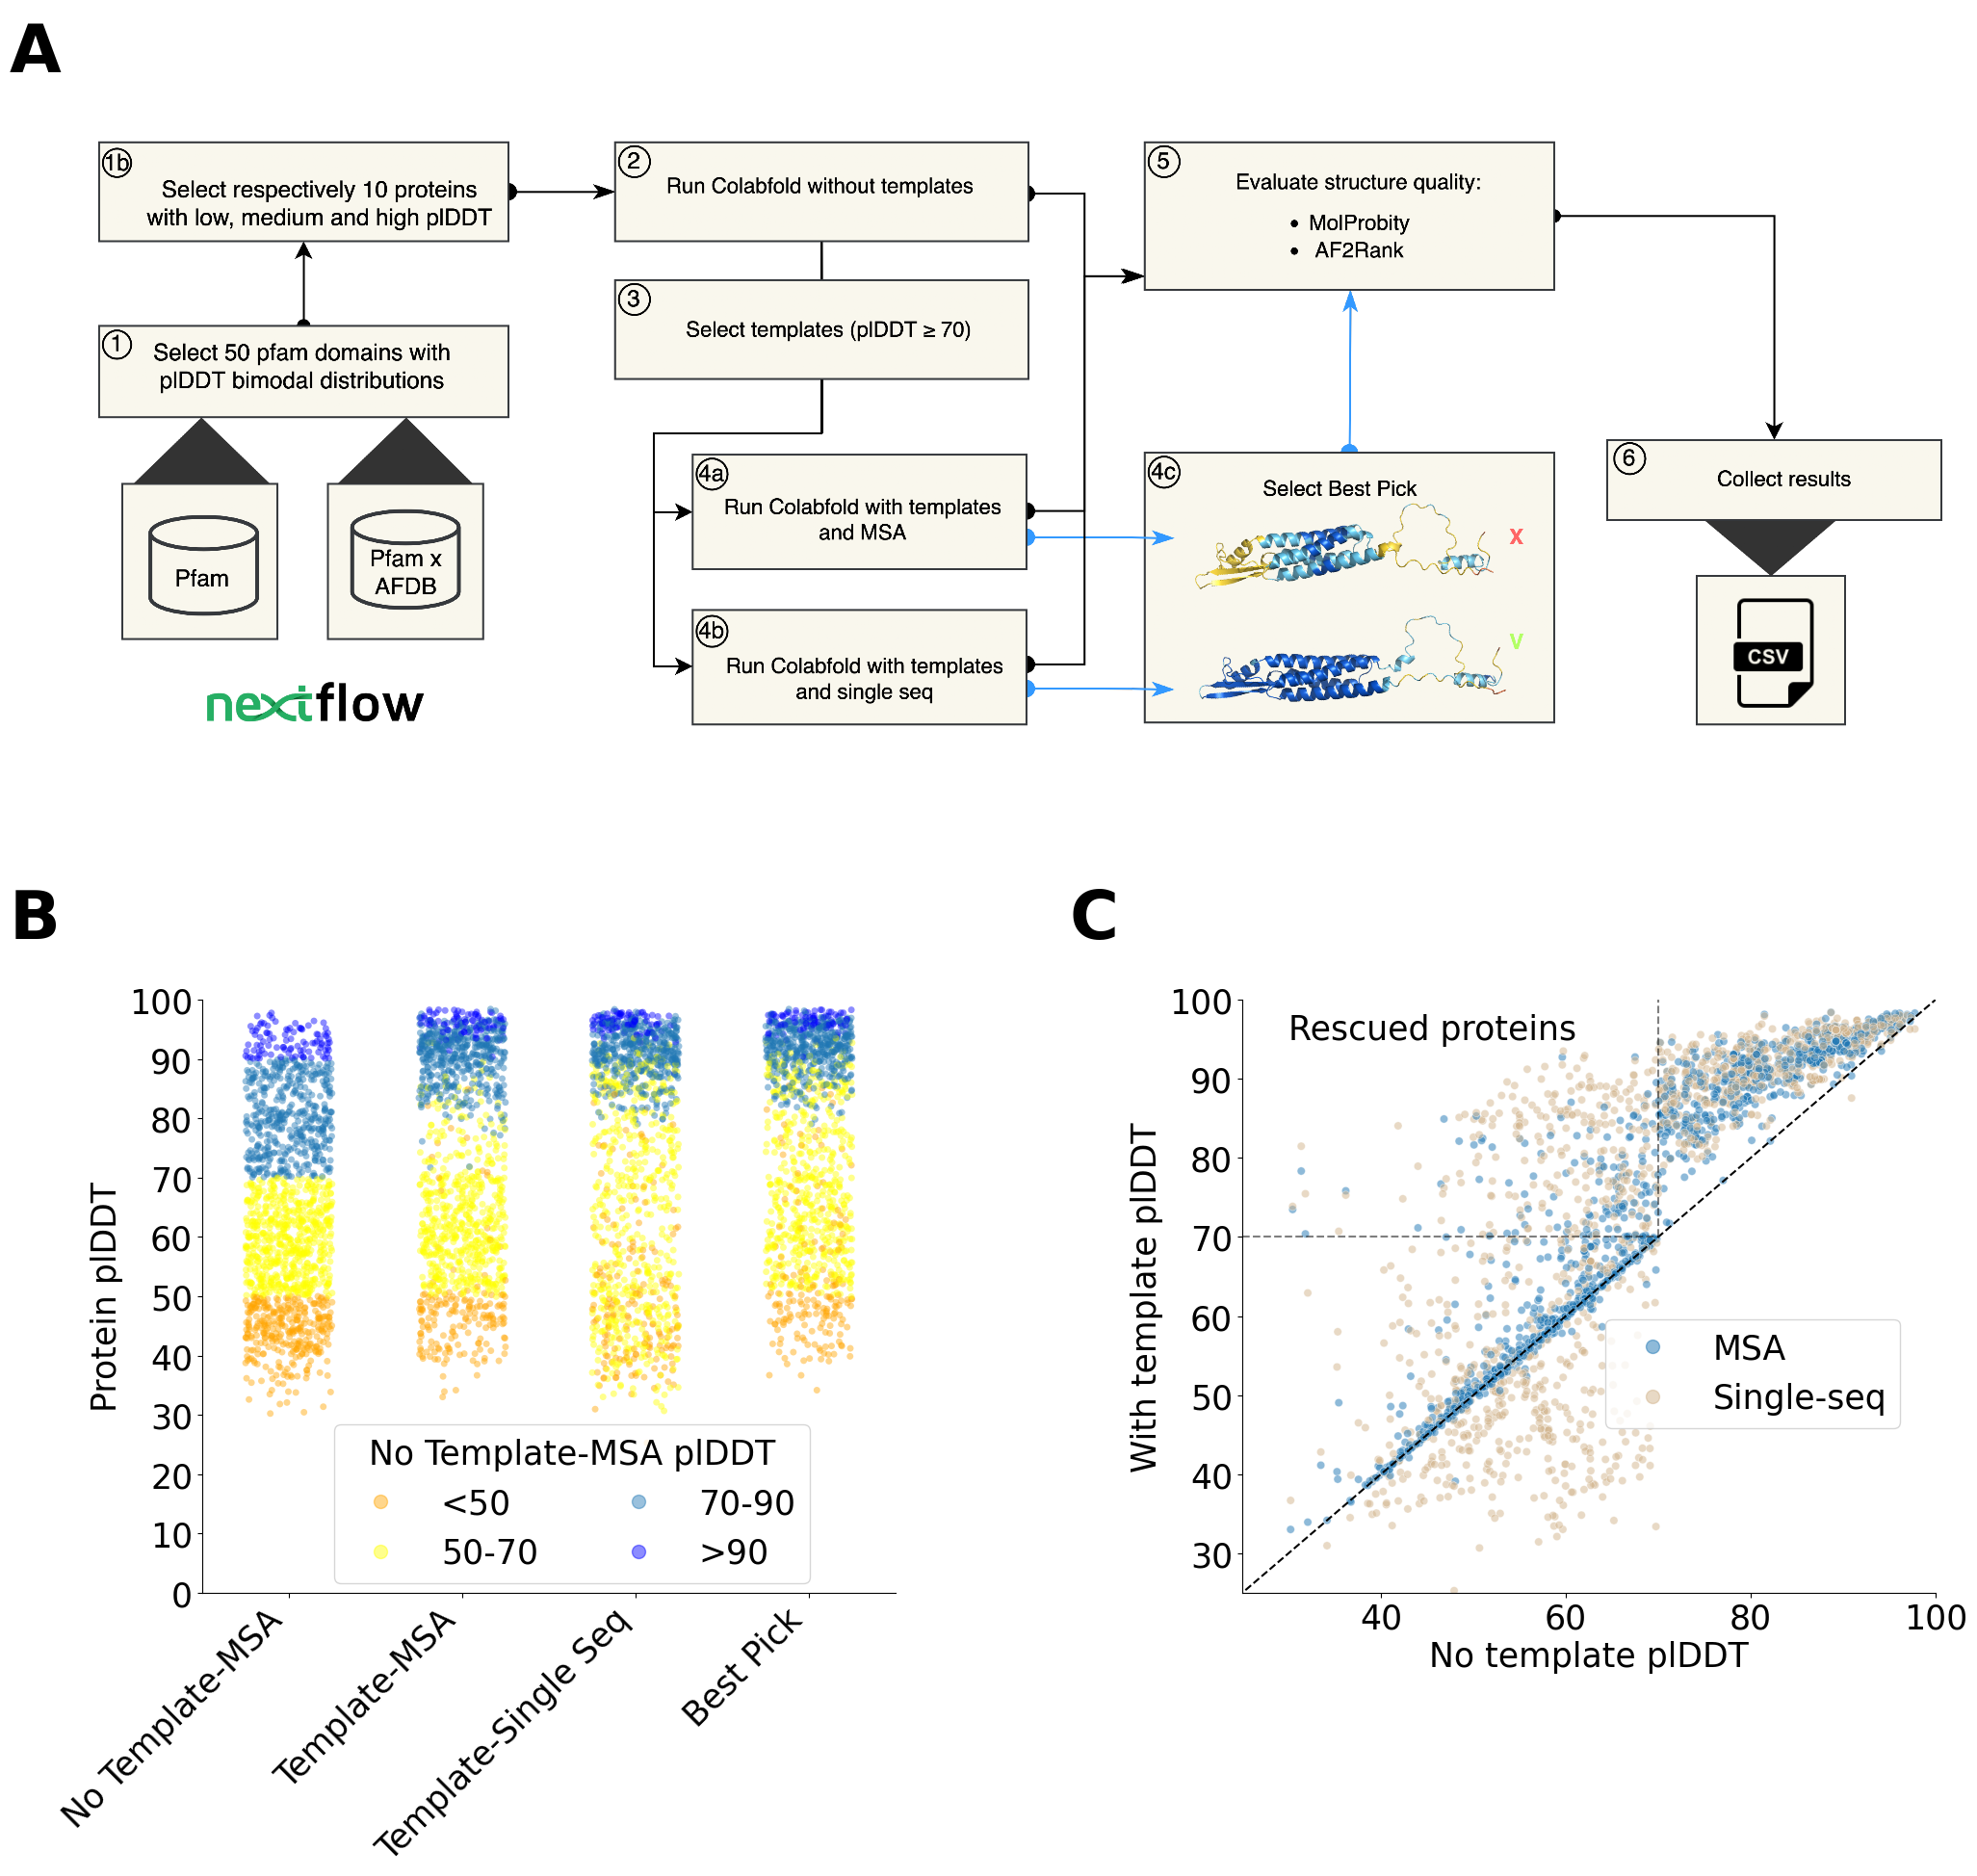

In [98]:
ms = 10
fig, ax = plt.subplots(2,2, figsize=[20,20])
plt.subplots_adjust(hspace=.5, 
                    wspace=.5,
                    left=0,
                    right=.9)
fig.text(-0.1,.9, "A", weight="bold", fontsize=ANNOT_FONT_SIZE)
#fig.text(.45,0.9, "B", weight="bold", fontsize=ANNOT_FONT_SIZE)
fig.text(-0.1,0.45, "B", weight="bold", fontsize=ANNOT_FONT_SIZE)
fig.text(0.45,0.45, "C", weight="bold", fontsize=ANNOT_FONT_SIZE)

# 1 & 2

ax[0,0].axis("off")
ax[0,1].axis("off")

arr_img = plt.imread(os.path.join(DATA_DIR, "workflow.png"))
im = OffsetImage(arr_img, zoom=.29)
ab = AnnotationBbox(im, xy=(0, 0), xybox=(-.15, -.15), box_alignment=(0, 0), bboxprops=dict(color="white"))
ax[0,0].add_artist(ab)
ax[0,0].set_zorder(0)
ax[0,0].text(.3,.5, "")

#3
plot_df = AF2_df[['uniprot_acc', 'condition', 'plddt', 'plddt_class']].drop_duplicates()
plot_df = plot_df[plot_df.condition.isin(['no_template', 'template_MSA', 'template_single_seq', 
                                          'best_pick_structure_plddt'])]

plot_df.condition = plot_df.condition.replace({'no_template': 'No Template-MSA', 'template_MSA': 'Template-MSA',
        'template_single_seq': 'Template-Single Seq', 'best_pick_structure_plddt': 'Best Pick'})

plot_df['condition'] = plot_df['condition'].astype('category')
plot_df['condition'] = plot_df['condition'].cat.set_categories(
    ['No Template-MSA', 'Template-MSA', 'Template-Single Seq', 'Best Pick'])


g = sns.stripplot(data=plot_df, y='plddt', x='condition', hue='plddt_class', color='black', alpha=.45, 
                  jitter=.25, hue_order=['Very low', 'Low', 'Confident', 'Very high'],
                  palette={'Very low': 'orange', 'Low': 'yellow', 'Confident':'C0', 'Very high': 'blue'}, legend=False,
                  dodge=False, ax=ax[1,0])
g.set_xticklabels(ax[1,0].get_xticklabels(), ha="right", rotation=45)

ax[1,0].set_ylabel('Protein plDDT')
ax[1,0].set_xlabel('')
ax[1,0].set_yticks([i for i in range(0, 110, 10)])
ax[1,0].set_ylim([0, 100])
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['top'].set_visible(False)

handles = [
    plt.Line2D([], [], color='orange', marker='o', linestyle='None', markersize=ms, alpha=.45),
    plt.Line2D([], [], color='yellow', marker='o', linestyle='None', markersize=ms, alpha=.45),
    plt.Line2D([], [], color='C0', marker='o', linestyle='None', markersize=ms, alpha=.45),
    plt.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=ms, alpha=.45),
    ]
labels = ['<50', '50-70', '70-90', '>90']

legend = ax[1,0].legend(handles, labels, 
                   frameon=True, facecolor=None, ncol=2, bbox_to_anchor=(0.9,0.15), loc="center right",
                   )
legend.set_title('No Template-MSA plDDT')

#4
plot_df = pd.merge(AF2_df[AF2_df.condition=='no_template'][['pfamA_acc', 'uniprot_acc', 'plddt', 'condition']].drop_duplicates()\
                   .rename(columns={'plddt': 'no_template-plddt'}),
                   AF2_df[AF2_df.condition.isin(['template_single_seq', 'template_MSA'])][['pfamA_acc', 'uniprot_acc', 'plddt', 'condition']]\
                   .drop_duplicates(), 
                   on= ['pfamA_acc', 'uniprot_acc'])

plot_df.condition_y = plot_df.condition_y.replace({'template_single_seq': 'Single seq', 
                                                  'template_MSA': 'MSA'})
plot_df = plot_df.rename(columns={'condition_y': 'condition'})

g = sns.scatterplot(plot_df, x='no_template-plddt', y='plddt', hue='condition', 
                palette={'MSA': 'C0', 'Single seq': 'tan'}, alpha=.5, ax=ax[1,1], legend=False)
handles = [
    plt.Line2D([], [], color='C0', marker='o', linestyle='None', markersize=ms, alpha=.5),
    plt.Line2D([], [], color='tan', marker='o', linestyle='None', markersize=ms, alpha=.5)
    ]
labels = ['MSA', 'Single-seq']
legend = ax[1,1].legend(handles, labels, loc='lower left', 
                   frameon=True, facecolor=None, ncol=1, bbox_to_anchor=(0.5,.25),
                   )
legend.set_title('')

ax[1,1].set_xlim([25,100])
ax[1,1].set_ylim([25,100])
ax[1,1].set_ylabel('With template plDDT')
ax[1,1].set_xlabel('No template plDDT')
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['top'].set_visible(False)

# add dotted lines
ax[1,1].vlines(x=70, ymin=70, ymax=100, color='black', linestyles='dashed', alpha=.5)
ax[1,1].hlines(y=70, xmin=25, xmax=70, color='black', linestyles='dashed', alpha=.5)
ax[1,1].axvspan(xmin=25,xmax=70, ymin=70, facecolor='green', alpha=0.2)
#plt.axhspan(25,70, facecolor='white', alpha=1)
ax[1,1].text(x=30, y=95, s='Rescued proteins')

# add red line
X_plot = np.linspace(0, 100, 100)
Y_plot = X_plot

ax[1,1].plot(X_plot, Y_plot, color='black', ls="--", alpha=1)

plt.savefig(os.path.join(FIGURES_DIR, 'figure2.png'), dpi=120,  transparent=False, bbox_inches='tight')

In [77]:
improvable_proteins = AF2_df[(AF2_df.condition=='no_template') & (AF2_df.plddt < 70)]\
    .uniprot_acc.unique()

stat_df = pd.merge(AF2_df[(AF2_df["condition"] == "no_template")&(AF2_df["uniprot_acc"].isin(improvable_proteins))]\
        [["pfamA_acc", "uniprot_acc", "plddt"]]\
                .rename(columns={"plddt": "no_template"}),
        AF2_df[(AF2_df["condition"] == "best_pick_structure_plddt")&(AF2_df["uniprot_acc"].isin(improvable_proteins))]\
                [["pfamA_acc", "uniprot_acc", "plddt"]]\
                .rename(columns={"plddt": "best_pick"}),
        on=["pfamA_acc", "uniprot_acc"])

wilcoxon(x=stat_df["no_template"], y=stat_df["best_pick"], alternative="less")

WilcoxonResult(statistic=183440.0, pvalue=0.0)

## Figure 3

In [79]:
# prepare molprobity data

plot_molp = pd.merge(df_molp, AF2_df[['pfamA_acc', 'uniprot_acc', 'condition', 'plddt']],
         on=['pfamA_acc', 'uniprot_acc', 'condition'])
plot_molp = get_best_condition(plot_molp, 'plddt')

improvable_proteins = AF2_df[(AF2_df.condition=='no_template') & (AF2_df.plddt < 70)]\
    .uniprot_acc.unique()
plot_molp = plot_molp[plot_molp.uniprot_acc.isin(improvable_proteins)]
uniprot_accs = [uniprot_acc for uniprot_acc in plot_molp[plot_molp.condition == 'no_template'].uniprot_acc.unique() if\
                uniprot_acc in plot_molp[plot_molp.condition == 'template_single_seq'].uniprot_acc.unique() and\
                uniprot_acc in plot_molp[plot_molp.condition == 'template_MSA'].uniprot_acc.unique() ]
plot_molp = plot_molp[plot_molp.uniprot_acc.isin(uniprot_accs)]
plot_molp = plot_molp.drop_duplicates()

In [80]:
# prepare af2rank data

improvable_proteins = AF2_df[(AF2_df.condition=='no_template') & (AF2_df.plddt < 70)]\
    .uniprot_acc.to_list()
plot_af2rank = df_rank[df_rank.uniprot_acc.isin(improvable_proteins)]

# consider also only proteins found in all three conditions to make up for AF2Rank errors
uniprot_accs = [uniprot_acc for uniprot_acc in plot_af2rank[plot_af2rank.condition == 'no_template'].uniprot_acc.unique() if\
                uniprot_acc in plot_af2rank[plot_af2rank.condition == 'template_single_seq'].uniprot_acc.unique() and\
                uniprot_acc in plot_af2rank[plot_af2rank.condition == 'template_MSA'].uniprot_acc.unique() ]
plot_af2rank = plot_af2rank[plot_af2rank.uniprot_acc.isin(uniprot_accs)]
plot_af2rank = pd.merge(plot_af2rank, AF2_df[['pfamA_acc', 'condition', 'uniprot_acc', 'plddt']], on=['pfamA_acc', 'uniprot_acc', 'condition'])
# add best pick
plot_af2rank = get_best_condition(plot_af2rank, 'plddt').drop_duplicates()

plot_af2rank['condition'] = plot_af2rank['condition'].astype('category')
plot_af2rank['condition'] = plot_af2rank['condition'].cat.set_categories(
    ['no_template', 'template_MSA', 'template_single_seq', 'best_pick'])

/tmp/ipykernel_3988188/1379343905.py:43: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  sns.violinplot(plot_af2rank.assign(condition=lambda x: x["condition"].replace({'no_template': 'No Template-MSA', 'template_MSA': 'Template-MSA',


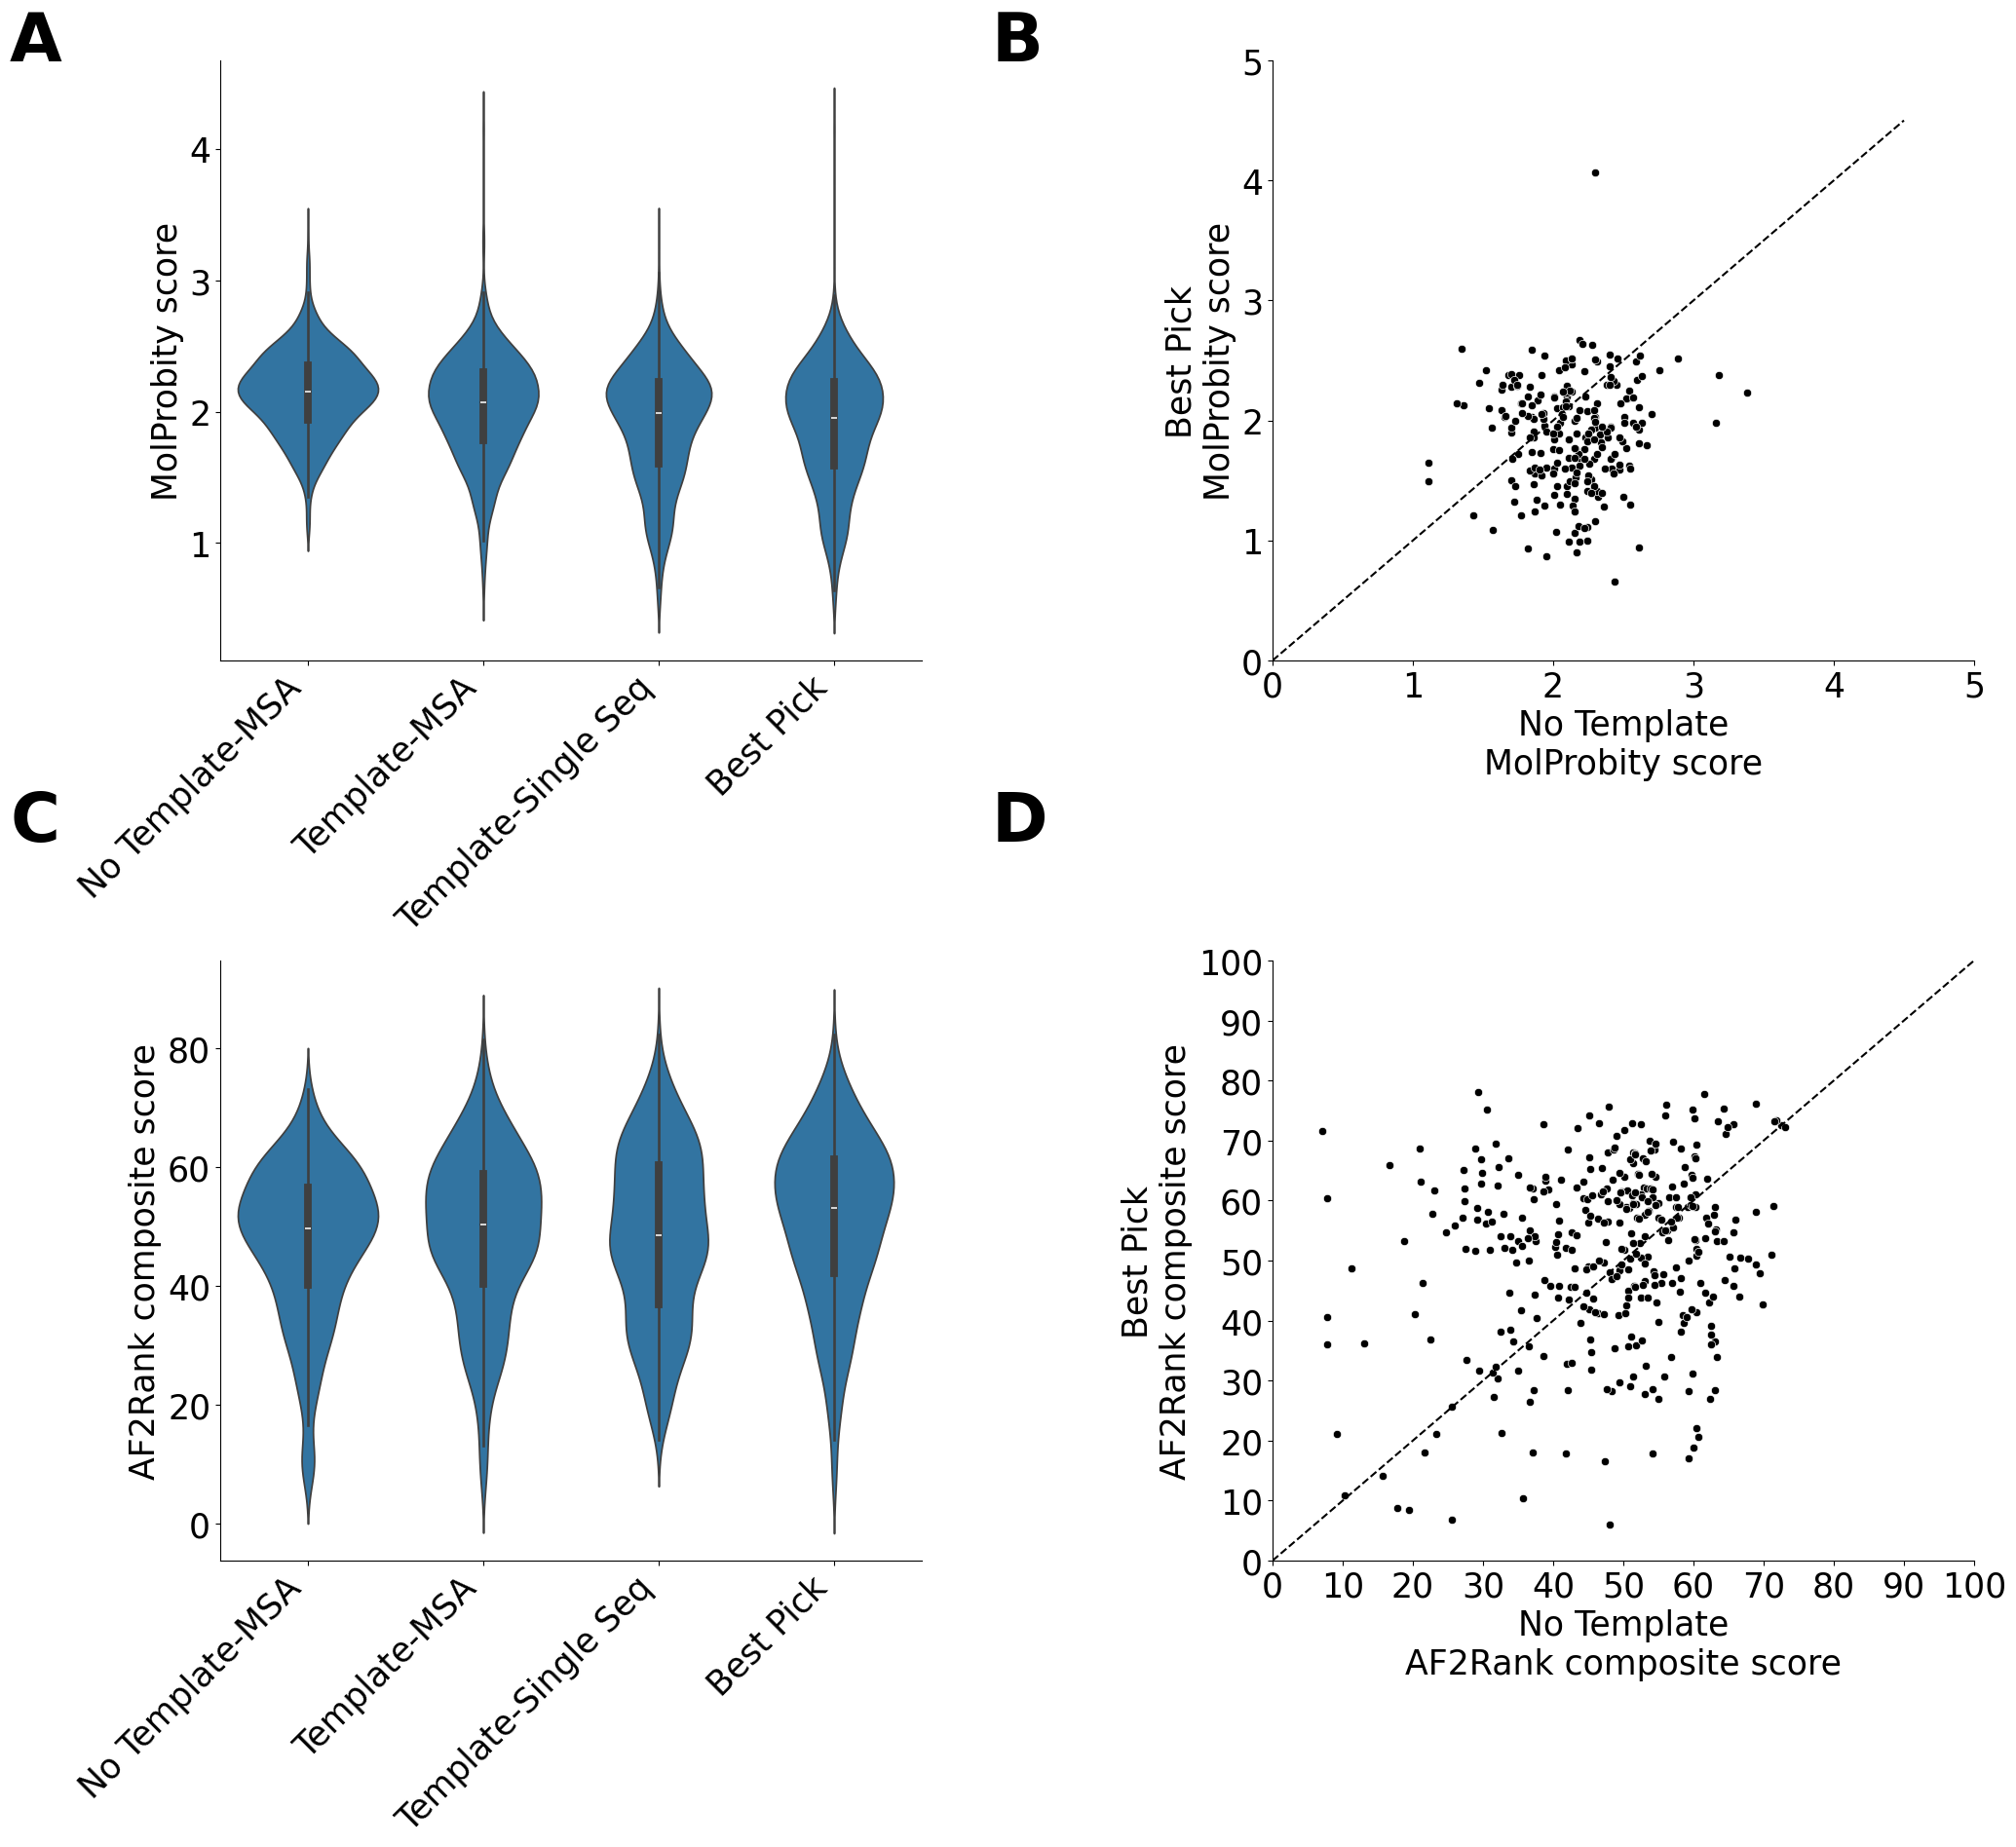

In [18]:
fig, ax = plt.subplots(2,2, figsize=[20,20])
plt.subplots_adjust(hspace=.5, 
                    wspace=.5,
                    left=0,
                    right=.9)
plt.text(-180,250, "A", weight="bold", fontsize=ANNOT_FONT_SIZE)
plt.text(-40,250, "B", weight="bold", fontsize=ANNOT_FONT_SIZE)
plt.text(-180,120, "C", weight="bold", fontsize=ANNOT_FONT_SIZE)
plt.text(-40,120, "D", weight="bold", fontsize=ANNOT_FONT_SIZE)

# 1

sns.violinplot(plot_molp.assign(condition=lambda x: x["condition"].replace({'no_template': 'No Template-MSA', 'template_MSA': 'Template-MSA',
        'template_single_seq': 'Template-Single Seq', 'best_pick': 'Best Pick'})),
                 x="condition", y="MolProbity score", ax=ax[0,0])
plt.setp(ax[0,0].get_xticklabels(), ha="right", rotation=45)

ax[0,0].set_xlabel("")
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['top'].set_visible(False)


# 2
sns.scatterplot(x=plot_molp[plot_molp["condition"]=="no_template"]["MolProbity score"],
                y=plot_molp[plot_molp["condition"]=="best_pick"]["MolProbity score"], color="black", ax=ax[0,1])

ax[0,1].set_xticks([i for i in range(0,6)])
ax[0,1].set_yticks([i for i in range(0,6)])
ax[0,1].set_xlim([0, 5])
ax[0,1].set_ylim([0, 5])

ax[0,1].set_xlabel("No Template\nMolProbity score")
ax[0,1].set_ylabel("Best Pick\nMolProbity score")

X_plot = np.linspace(0, 4.5)
Y_plot = X_plot
ax[0,1].plot(X_plot, Y_plot, color='black', ls="--")

ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['top'].set_visible(False)

# 3
sns.violinplot(plot_af2rank.assign(condition=lambda x: x["condition"].replace({'no_template': 'No Template-MSA', 'template_MSA': 'Template-MSA',
        'template_single_seq': 'Template-Single Seq', 'best_pick': 'Best Pick'})),
                 x="condition", y="af2rank_composite", ax=ax[1,0])
plt.setp(ax[1,0].get_xticklabels(), ha="right", rotation=45)

ax[1,0].set_xlabel("")
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['top'].set_visible(False)
ax[1,0].set_ylabel('AF2Rank composite score')

# 4
sns.scatterplot(x=plot_af2rank[plot_af2rank["condition"]=="no_template"]["af2rank_composite"],
                y=plot_af2rank[plot_af2rank["condition"]=="best_pick"]["af2rank_composite"], color="black", ax=ax[1,1])

ax[1,1].set_xticks([i for i in range(0,110,10)])
ax[1,1].set_yticks([i for i in range(0,110,10)])
ax[1,1].set_xlim([0,100])
ax[1,1].set_ylim([0,100])

ax[1,1].set_xlabel("No Template\nAF2Rank composite score")
ax[1,1].set_ylabel("Best Pick\nAF2Rank composite score")

X_plot = np.linspace(0,100)
Y_plot = X_plot
ax[1,1].plot(X_plot, Y_plot, color='black', ls="--")

ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['top'].set_visible(False)


plt.savefig(os.path.join(FIGURES_DIR, 'figure3.png'), dpi=400,  transparent=False, bbox_inches='tight')

In [81]:
stat_df = pd.merge(plot_molp[plot_molp["condition"] == "no_template"][["pfamA_acc", "uniprot_acc", "MolProbity score"]]\
                .rename(columns={"MolProbity score": "no_template"}),
        plot_molp[plot_molp["condition"] == "best_pick"][["pfamA_acc", "uniprot_acc", "MolProbity score"]]\
                .rename(columns={"MolProbity score": "best_pick"}),
        on=["pfamA_acc", "uniprot_acc"])

wilcoxon(x=stat_df["no_template"], y=stat_df["best_pick"], alternative="greater")
    

WilcoxonResult(statistic=202646.0, pvalue=2.6140832506747372e-45)

In [82]:
stat_df = pd.merge(plot_af2rank[plot_af2rank["condition"] == "no_template"][["pfamA_acc", "uniprot_acc", "af2rank_composite"]]\
                .rename(columns={"af2rank_composite": "no_template"}),
        plot_af2rank[plot_af2rank["condition"] == "best_pick"][["pfamA_acc", "uniprot_acc", "af2rank_composite"]]\
                .rename(columns={"af2rank_composite": "best_pick"}),
        on=["pfamA_acc", "uniprot_acc"])

wilcoxon(x=stat_df["no_template"], y=stat_df["best_pick"], alternative="less")
    

WilcoxonResult(statistic=82551.0, pvalue=5.179452473583665e-19)

## Figure S1

In [ ]:
df = pd.read_csv(os.path.join(DATA_DIR, "afdb_protein_info.csv"), sep=",")
domains_analysed = df["pfam_id"].unique()[:50]
with open(os.path.join(DATA_DIR, 'distributions.json'), 'r') as handle:
    dist_dic = json.load(handle)
# normalize values
for pfam_id in dist_dic.keys():
    total = total = sum(dist_dic[pfam_id])
    dist_dic[pfam_id] = [dist_dic[pfam_id][i] / total for i in range(100)]

# convert to desired format and filter by domains of interest
outlist = []
for pfamA_acc in dist_dic.keys():
    if pfamA_acc in domains_analysed:
        for plddt, freq in enumerate(dist_dic[pfamA_acc]):
            outlist.append([pfamA_acc, plddt+1, freq])

dist_df = pd.DataFrame(outlist, columns = ["pfamA_acc", "x", "y"])
#dist_df = dist_df.iloc[:4000]

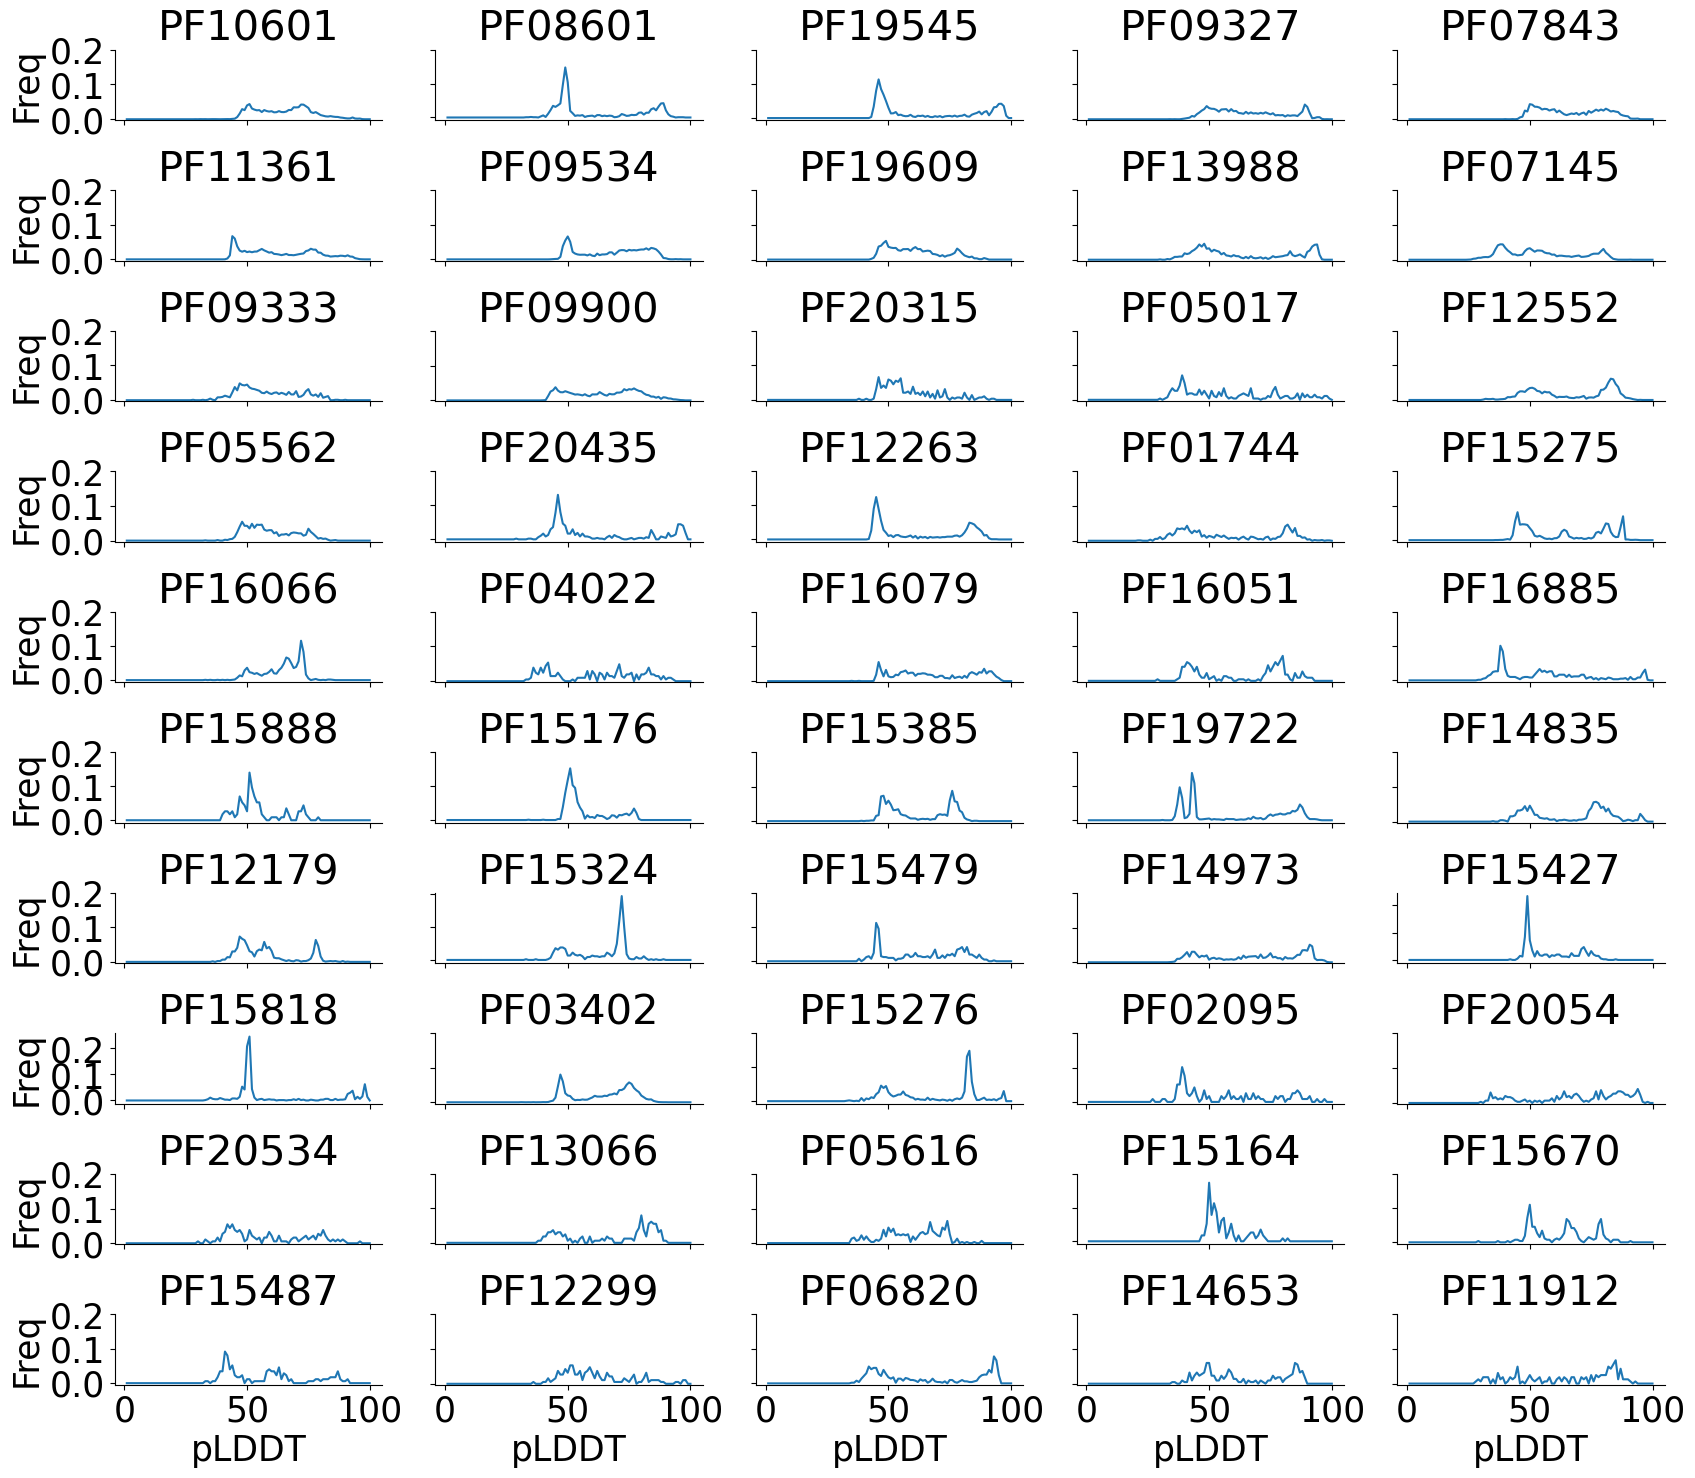

In [ ]:
nrows=10
ncols=5

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=[20,15])
plt.subplots_adjust(left=None, bottom=None, right=None, top=1, wspace=None, hspace=1)

axes = [[row, col] for row in range(nrows) for col in range(ncols)]
for indx, pfamA_acc in zip(axes, dist_df.pfamA_acc.unique()):
    ax = axs[indx[0], indx[1]]
    x = dist_df[dist_df.pfamA_acc == pfamA_acc]['x']
    y = dist_df[dist_df.pfamA_acc == pfamA_acc]['y']
    ax.plot(x, y)
    ax.set_title(pfamA_acc, weight='normal')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if indx[0] == nrows-1:
        ax.set_xticks([0,50,100])
        ax.set_xlabel("pLDDT", weight="normal")
    else:
       ax.set(xticks=[0,50,100], xlabel="")
       plt.setp(ax.get_xticklabels(), visible=False)
    
    if indx[1] == 0:
        ax.set(yticks=[0,0.1,0.2])
        ax.set_ylabel("Freq", weight="normal")
    else:
        ax.set(yticks=[0,0.1,0.2])
        plt.setp(ax.get_yticklabels(), visible=False)



#g.despine(bottom=True, left=True)
#plt.xlabel("Domain pLDDT",weight="bold")
#plt.ylabel("Frequency", weight="bold")
plt.savefig(os.path.join(FIGURES_DIR, 'figureS1.png'), dpi=400, transparent=True, bbox_inches='tight')
plt.show()

## Figure S2

In [43]:
# read in template data
if os.path.isfile(os.path.join(CACHE_DIR, 'similarity.csv')) == False:

    result_dir = os.path.join(RESULT_DIR,'AF2')
    input_dir = os.path.join(RESULT_DIR,'AF2')
    outlist = []
    for condition in ['template_MSA']:
        for domain in filter(lambda x: x.startswith('PF'),  os.listdir(os.path.join(result_dir, condition))):
            template_mapper = None
            try:
                with open(os.path.join(input_dir, 'templates', domain, '.mapper.json'), 'r') as fp:
                    template_mapper = json.load(fp)
                template_mapper_lookup = {v: k for k, v in template_mapper.items()}
            except Exception as e:
                print(domain, e)
            if template_mapper != None:

                for file in filter(lambda x: '_relaxed_rank_001' in x and x.endswith('.pdb'),
                                os.listdir(os.path.join(result_dir, condition, domain))):
                    logpath = os.path.join(result_dir, condition, domain, 'log.txt')
                    uniprot_acc = file.split('_')[0] 
                    templates = get_domains_from_log(logpath, uniprot_acc)
                    for template in templates:
                        template_code = template.split('_')[0]
                        template = os.path.join(input_dir, 'templates', domain, template_code + '.cif')
                        target = str(list(SeqIO.parse(template, "cif-atom"))[0].seq)
                        query = str(list(SeqIO.parse(os.path.join(result_dir, condition, domain, file), 'pdb-atom'))[0].seq)
                        seq_identity = align_seqs(query, target)
                        outlist.append([condition, domain, uniprot_acc, template_mapper_lookup[template_code].split('_')[0], seq_identity])   
                        if uniprot_acc == template_mapper_lookup[template_code].split('_')[0]:
                            #print(uniprot_acc, template_mapper_lookup[template_code].split('_')[0], seq_identity)     
                            assert seq_identity >= 100, f"Seq identity is wrong, {uniprot_acc} {seq_identity}"      

    id_df = pd.DataFrame(outlist, columns=['condition', 'pfamA_acc', 'uniprot_acc', 'template_acc', 'seq_identity'])
    del id_df['condition']  
    id_df.to_csv(os.path.join(CACHE_DIR, 'similarity.csv'), index = False)
else:
    id_df = pd.read_csv(os.path.join(CACHE_DIR, 'similarity.csv'))
            

/tmp/ipykernel_2004524/1217193577.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delta_df['plddt_delta'] = left_df['plddt'] - right_df['plddt']
/tmp/ipykernel_2004524/1217193577.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delta_df['plddt_delta'] = left_df['plddt'] - right_df['plddt']


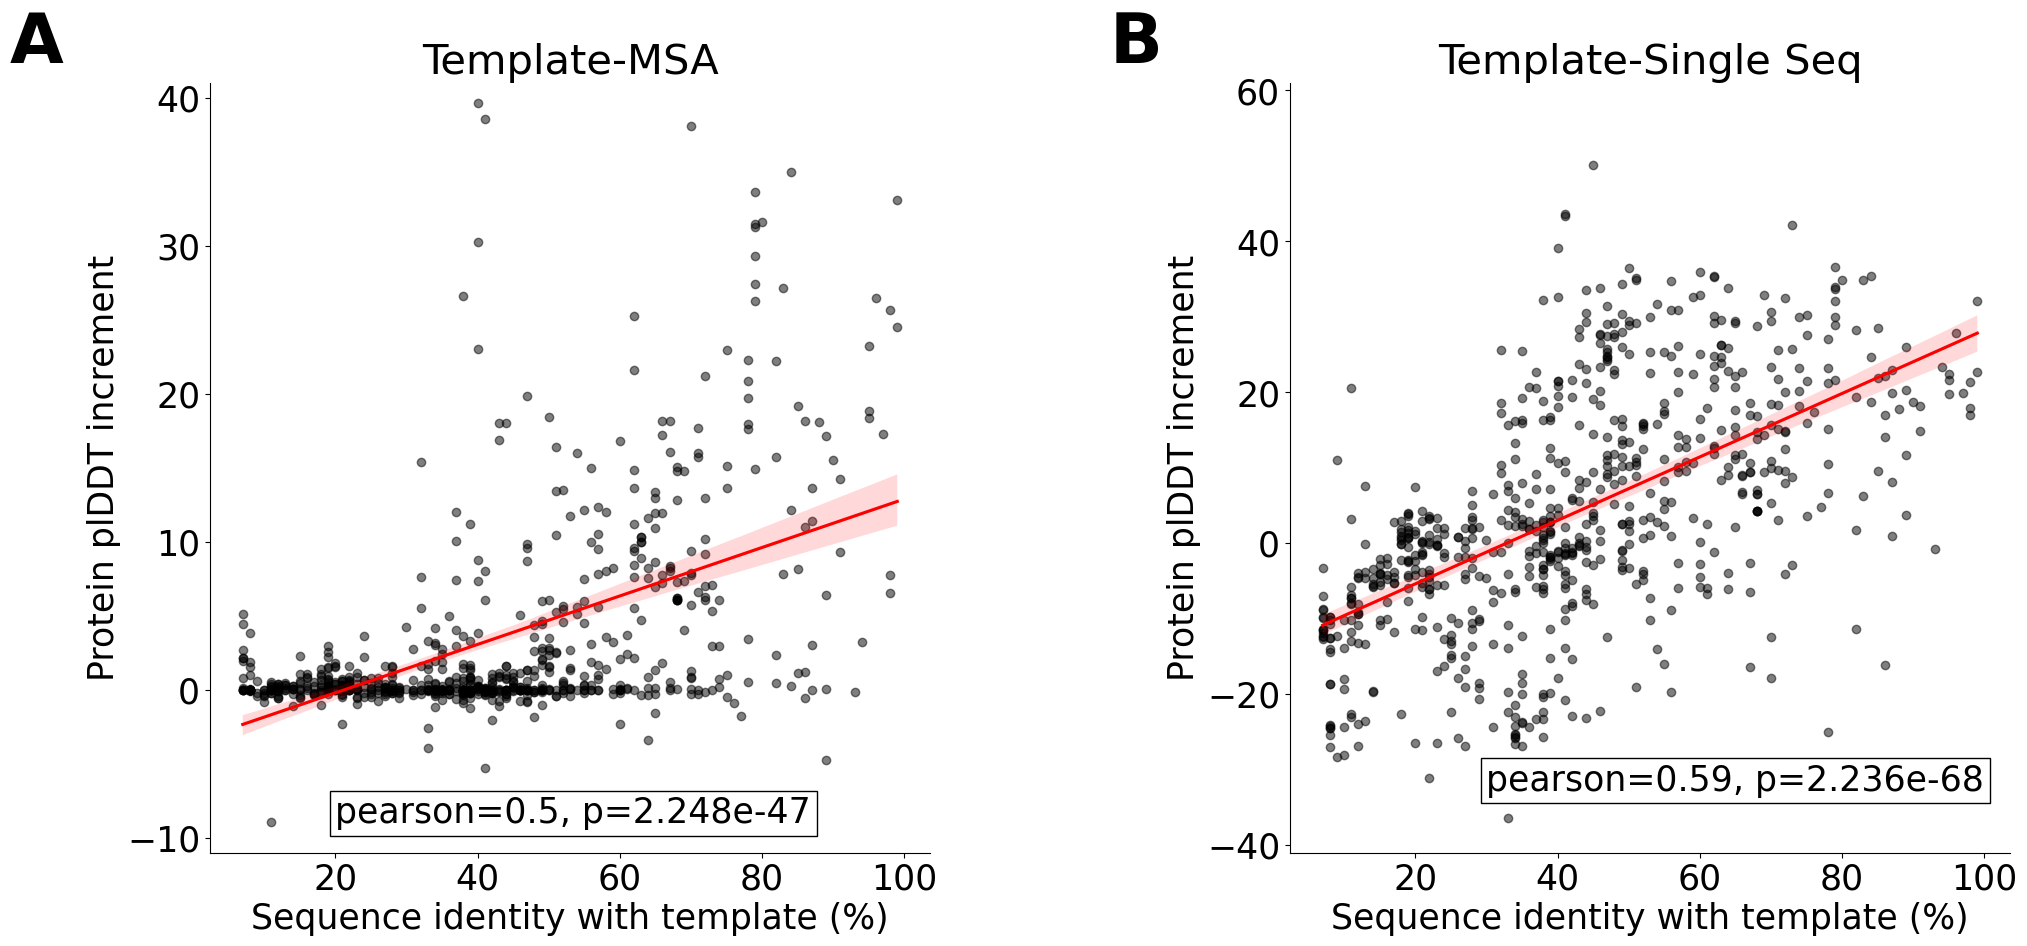

In [48]:
ms = 10
fig, ax = plt.subplots(1,2, figsize=[20,10])
plt.subplots_adjust(hspace=.5, 
                    wspace=.5,
                    left=0,
                    right=.9)
fig.text(-0.1,.9, "A", weight="bold", fontsize=ANNOT_FONT_SIZE)
fig.text(.45,0.9, "B", weight="bold", fontsize=ANNOT_FONT_SIZE)


#1
# consider only improvable proteins and protein found in all conditions
improvable_proteins = AF2_df[(AF2_df.condition=='no_template') & (AF2_df.plddt < 70)]\
    .uniprot_acc.unique()
uniprot_accs = [uniprot_acc for uniprot_acc in improvable_proteins if uniprot_acc in 
                AF2_df[AF2_df.condition == 'no_template'].uniprot_acc.to_list() and uniprot_acc in
                AF2_df[AF2_df.condition == 'template_single_seq'].uniprot_acc.to_list() and
                AF2_df[AF2_df.condition == 'template_MSA'].uniprot_acc.to_list()]

plot_df = id_df.groupby(['pfamA_acc','uniprot_acc']).max()
plot_df = plot_df.reset_index()

plot_df = pd.merge(plot_df, AF2_df[(AF2_df.condition == 'template_MSA')]\
                   [['pfamA_acc', 'uniprot_acc', 'plddt']].drop_duplicates(),
          on=['pfamA_acc', 'uniprot_acc'])
plot_df = plot_df[plot_df.uniprot_acc.isin(uniprot_accs)]

# get plddt delta
delta_df = AF2_df[(AF2_df.uniprot_acc.isin(uniprot_accs))]\
                    [['pfamA_acc', 'uniprot_acc', 'condition', 'plddt']].drop_duplicates()
delta_df.condition = delta_df.condition.replace({'best_pick_structure_plddt': 'best_pick'})
delta_df = delta_df.set_index(['pfamA_acc', 'uniprot_acc'])
left_df, right_df = delta_df[delta_df.condition == 'template_MSA'].align(delta_df[delta_df.condition == 'no_template'])
delta_df = left_df[[]]
delta_df['plddt_delta'] = left_df['plddt'] - right_df['plddt']
delta_df = delta_df.reset_index()

plot_df = pd.merge(plot_df, delta_df, on=['pfamA_acc', 'uniprot_acc'])
_ = sns.regplot(x='seq_identity', y='plddt_delta', data=plot_df, ci=95, ax=ax[0],
                scatter_kws={'alpha':0.5, 'color': 'black'},
                line_kws={'color':"r"})
r, p = stats.pearsonr(plot_df.seq_identity, plot_df.plddt_delta)
ax[0].text(x=20,y=-9,s='pearson={:0.2}, p={:0.3e}'.format(r, p),
             bbox=dict(facecolor='none', edgecolor='black'))

ax[0].set_ylabel('Protein plDDT increment')
ax[0].set_xlabel('Sequence identity with template (%)')
ax[0].set_title('Template-MSA')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_ylim([-11, 41])

#4
improvable_proteins = AF2_df[(AF2_df.condition=='no_template') & (AF2_df.plddt < 70)]\
    .uniprot_acc.unique()
uniprot_accs = [uniprot_acc for uniprot_acc in improvable_proteins if uniprot_acc in 
                AF2_df[AF2_df.condition == 'no_template'].uniprot_acc.to_list() and uniprot_acc in
                AF2_df[AF2_df.condition == 'template_single_seq'].uniprot_acc.to_list() and
                AF2_df[AF2_df.condition == 'template_MSA'].uniprot_acc.to_list()]

plot_df = id_df.groupby(['pfamA_acc','uniprot_acc']).max()
plot_df = plot_df.reset_index()

plot_df = pd.merge(plot_df, AF2_df[(AF2_df.condition == 'best_pick_structure_plddt')]\
                   [['pfamA_acc', 'uniprot_acc', 'plddt']].drop_duplicates(),
          on=['pfamA_acc', 'uniprot_acc'])
plot_df = plot_df[plot_df.uniprot_acc.isin(uniprot_accs)]

# get plddt delta
delta_df = AF2_df[(AF2_df.uniprot_acc.isin(uniprot_accs))]\
                    [['pfamA_acc', 'uniprot_acc', 'condition', 'plddt']].drop_duplicates()
delta_df.condition = delta_df.condition.replace({'best_pick_structure_plddt': 'best_pick'})
delta_df = delta_df.set_index(['pfamA_acc', 'uniprot_acc'])
left_df, right_df = delta_df[delta_df.condition == 'template_single_seq'].align(delta_df[delta_df.condition == 'no_template'])
delta_df = left_df[[]]
delta_df['plddt_delta'] = left_df['plddt'] - right_df['plddt']
delta_df = delta_df.reset_index()
plot_df = pd.merge(plot_df, delta_df, on=['pfamA_acc', 'uniprot_acc'])

_ = sns.regplot(x='seq_identity', y='plddt_delta', data=plot_df, ci=95, ax = ax[1],
                scatter_kws={'alpha':0.5, 'color': 'black'},
                line_kws={'color':"r"})
r, p = stats.pearsonr(plot_df.seq_identity, plot_df.plddt_delta)
ax[1].text(x=30,y=-32.8,s='pearson={:0.2}, p={:0.3e}'.format(r, p),
             bbox=dict(facecolor='none', edgecolor='black'))

ax[1].set_ylabel('Protein plDDT increment')
ax[1].set_xlabel('Sequence identity with template (%)')
ax[1].set_title('Template-Single Seq')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_ylim([-41, 61])

plt.savefig(os.path.join(FIGURES_DIR, 'figureS2.png'), dpi=400, transparent=True, bbox_inches='tight')

## Figure S3

In [ ]:
# analyse MSAs
outlist = []

for pfamA_acc in os.listdir(os.path.join(RESULT_DIR, 'AF2', 'MSAs')):
    for msa in os.listdir(os.path.join(RESULT_DIR, 'AF2', 'MSAs', pfamA_acc)):
        uniprot_acc = msa.replace('.a3m', '')
        msa_path = os.path.join(RESULT_DIR, 'AF2', 'MSAs', pfamA_acc, msa)
        outlist.append([pfamA_acc, uniprot_acc, len(list(SeqIO.parse(msa_path, 'fasta')))])

In [ ]:
msa_df = pd.DataFrame(outlist, columns=['pfamA_acc', 'uniprot_acc', 'msa_length'])
msa_df['msa_seqs_norm'] = 0 
for uniprot_acc in msa_df.uniprot_acc.unique():
    pfamA_acc = msa_df[msa_df.uniprot_acc == uniprot_acc].pfamA_acc.unique()[0]
    msa_df.loc[msa_df.uniprot_acc == uniprot_acc, 'msa_seqs_norm'] = msa_df.loc[msa_df.uniprot_acc == uniprot_acc, 'msa_length'] \
        / max(msa_df[msa_df.pfamA_acc == pfamA_acc].msa_length.to_list())

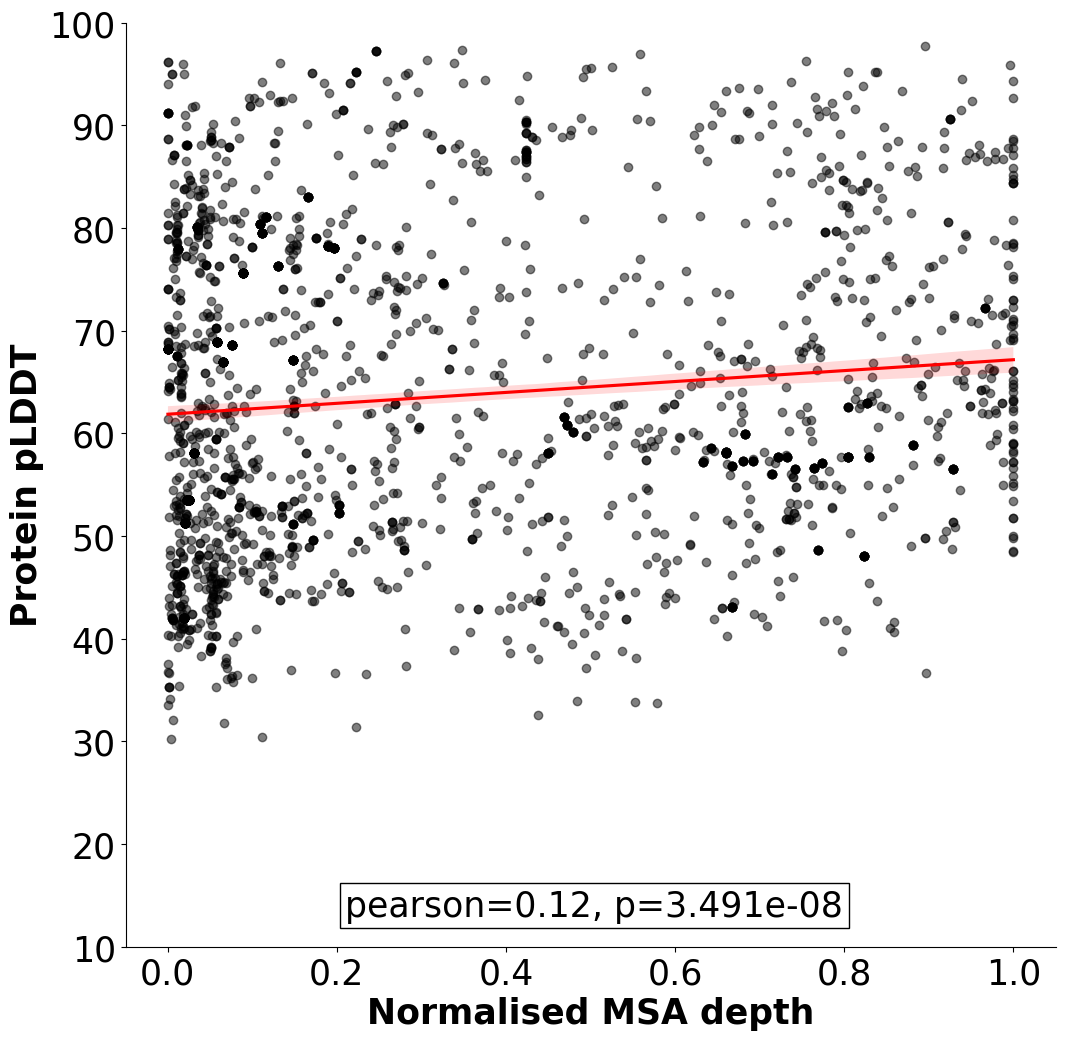

In [ ]:
fig, ax = plt.subplots(figsize=[12,12])

plot_df = pd.merge(AF2_df[['uniprot_acc', 'pfamA_acc', 'condition', 'plddt']], msa_df, on=['uniprot_acc', 'pfamA_acc'])
plot_df = plot_df[plot_df.condition == 'no_template']

j = sns.regplot(x='msa_seqs_norm', y='plddt', data=plot_df, ci=95, ax = ax,
                scatter_kws={'alpha':0.5, 'color': 'black'},
                line_kws={'color':"r"})

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

r, p = stats.pearsonr(plot_df.plddt, plot_df.msa_seqs_norm)
ax.text(x=0.21,y=13,s='pearson={:0.2}, p={:0.3e}'.format(r, p),
             bbox=dict(facecolor='none', edgecolor='black'))
plt.xlabel('Normalised MSA depth')
plt.ylabel('Protein pLDDT')
plt.ylim([10,100])
plt.savefig(os.path.join(FIGURES_DIR, 'figureS3.png'), dpi=400, transparent=True, bbox_inches='tight')

## Figure S4

In [49]:
result_dir = Path(RESULT_DIR).joinpath('AF2')

# exclude domains for which only no template data is available
domains_to_exclude = []

df = pd.DataFrame(columns = ['condition', 'pfamA_acc', 'uniprot_acc', 'model', 'recycle', 'plddt', 'ptm', 'tol', 'delta_t'])

for condition in CONDITIONS:
    cond_dir = result_dir.joinpath(condition)
    for p_domain in filter(lambda x: str(x.name).startswith('PF'), cond_dir.iterdir()):
        
        p = p_domain
        pfamA_acc = p_domain.name
        try:    
            logfile = p.joinpath("log.txt")
            tmp_df = get_log_data_wo_relaxation(logfile)
            tmp_df['condition'] = condition
            tmp_df['pfamA_acc'] = pfamA_acc
            df = pd.concat([df, tmp_df])
            
        except Exception as e:
            domains_to_exclude.append(pfamA_acc)
df = df[df.pfamA_acc.isin(domains_to_exclude) == False]

/tmp/ipykernel_2004524/1376131406.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, tmp_df])


In [50]:
# check what recycle early stop on average

# find the first tol < 0.5 A per model

outlist = []
tmp_df = df[df.recycle != 0]
tol_found = False
#tmp_df = tmp_df.iloc[:20]

for i in range(1, len(tmp_df.index)):
    if tmp_df.iloc[i - 1].model != tmp_df.iloc[i].model:
        tol_found = False

    if tmp_df.iloc[i].tol < 0.5 and tol_found == False:
        outlist.append(tmp_df.iloc[i].to_list())
        tol_found = True
    
    # consider cases in which tol <= .5 was never reached
    if tmp_df.iloc[i].recycle == 5 and tol_found == False:
        outlist.append(tmp_df.iloc[i].to_list())

tol_df = pd.DataFrame(outlist, columns=df.columns)

# safety checks
assert len(df) / 6 == len(tol_df)
assert len(tol_df) == len(tol_df.drop_duplicates())

/tmp/ipykernel_2004524/3044570545.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), ha="right", rotation=45)


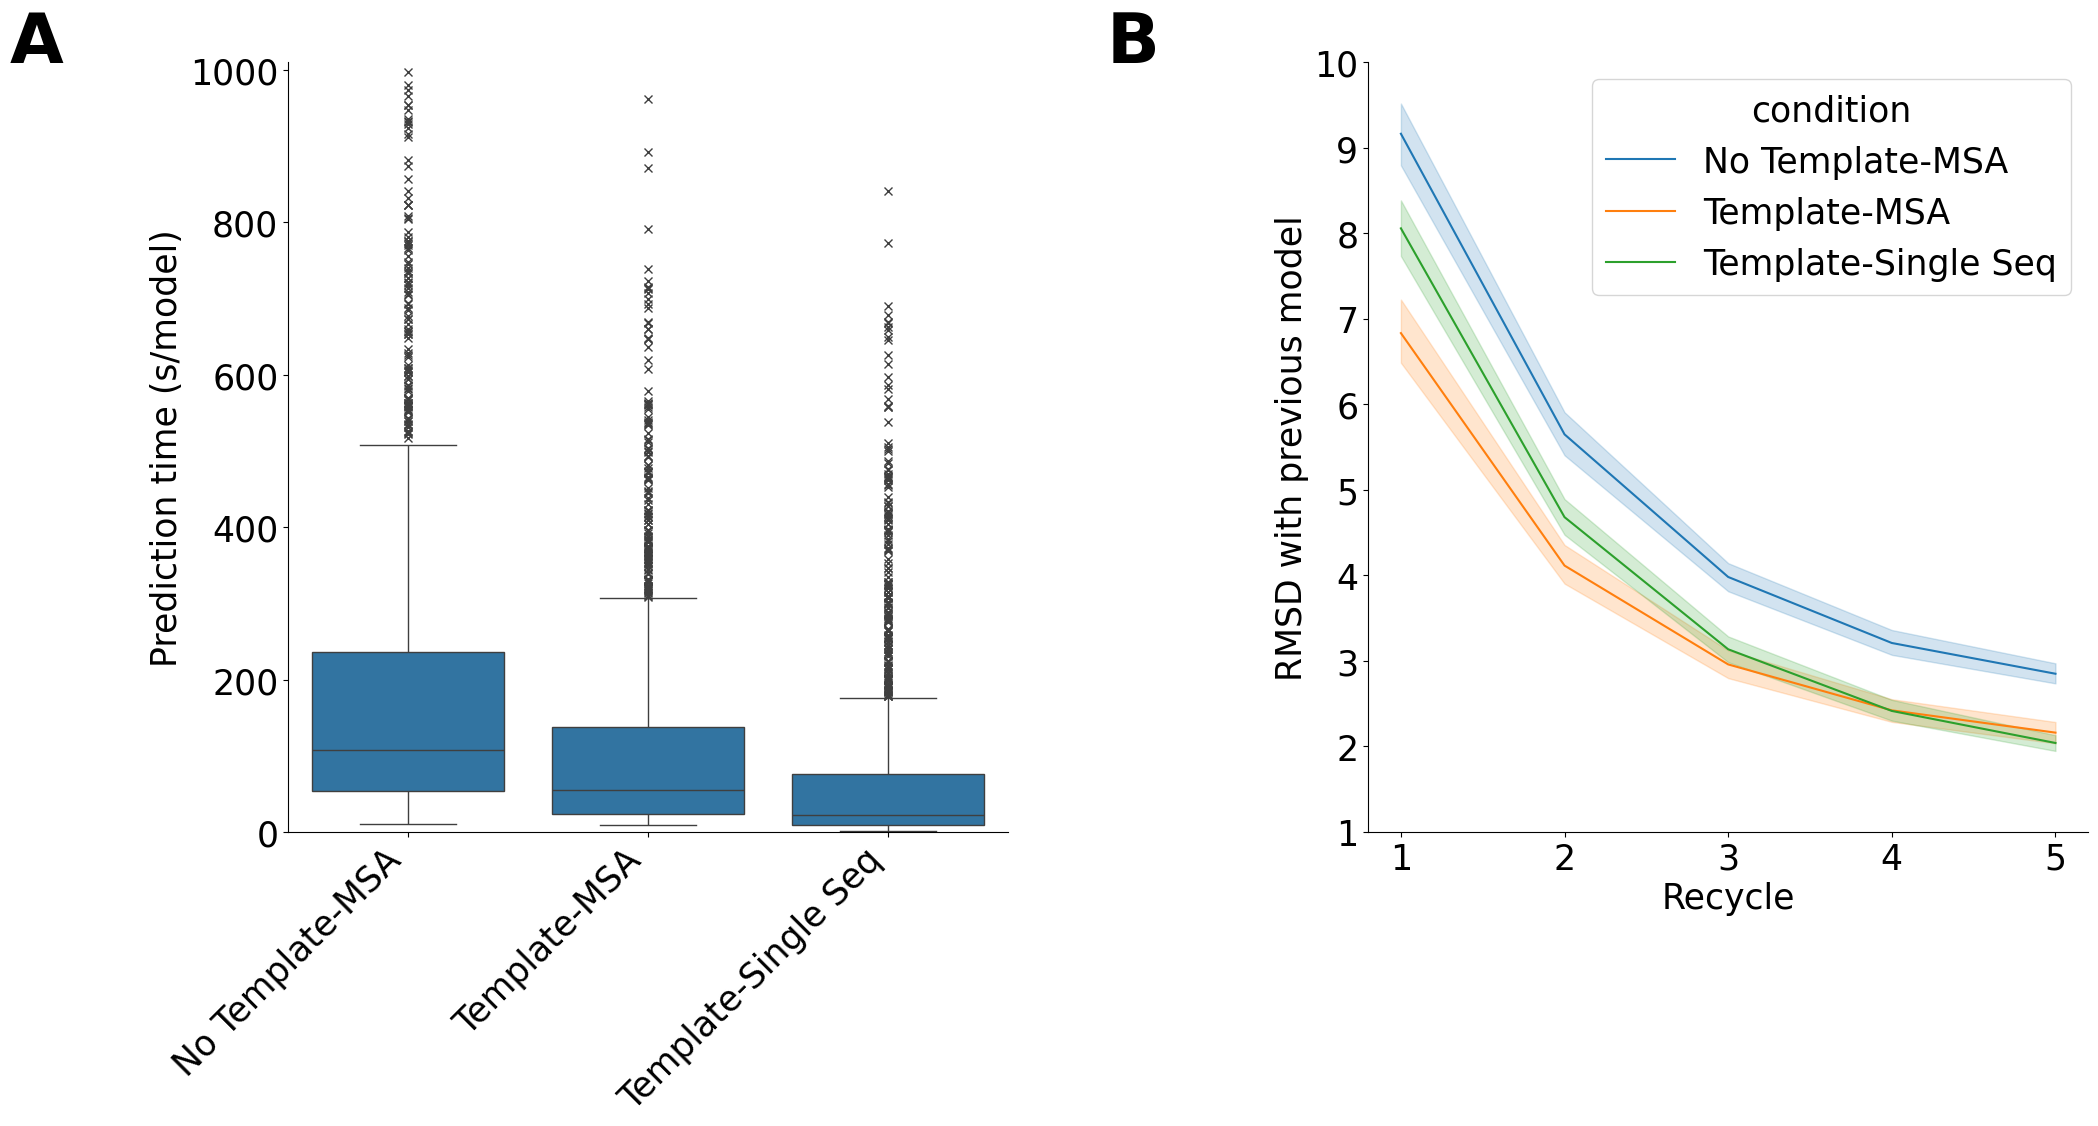

In [97]:
fig, ax = plt.subplots(ncols=2, figsize=[20,10])
plt.subplots_adjust(hspace=.5, 
                    wspace=.5,
                    left=0,
                    right=.9)
plt.text(-7.5,10, "A", weight="bold", fontsize=ANNOT_FONT_SIZE)
plt.text(-.8,10, "B", weight="bold", fontsize=ANNOT_FONT_SIZE)

#1
plot_df = df[['condition', 'uniprot_acc', 'delta_t', 'recycle']].groupby(['condition', 'uniprot_acc', 'recycle']).mean('delta_t')\
          .groupby(['condition', 'uniprot_acc']).sum('delta_t')
plot_df = plot_df.reset_index()
plot_df.condition = plot_df.condition.replace({'no_template': 'No Template-MSA', 'template_MSA': 'Template-MSA', 'template_single_seq':
                                  'Template-Single Seq'})
g=sns.boxplot(plot_df, y='delta_t', x="condition", ax=ax[0], flierprops={"marker": "x"},
           order=['No Template-MSA', 'Template-MSA', 'Template-Single Seq'])
g.set_xticklabels(g.get_xticklabels(), ha="right", rotation=45)
ax[0].set_ylim([0,1010])
ax[0].set_ylabel("Prediction time (s/model)")
ax[0].set_xlabel('')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

#2

plot_df = df[df.recycle != 0][['condition', 'recycle', 'tol', 'uniprot_acc']].groupby(['condition', 'recycle', 'uniprot_acc']).mean('tol')
plot_df = plot_df.reset_index()
plot_df.condition = plot_df.condition.replace({'no_template': 'No Template-MSA', 'template_MSA': 'Template-MSA', 'template_single_seq':
                                  'Template-Single Seq'})
plot_df.recycle = plot_df.recycle.astype(int)
sns.lineplot(data=plot_df, x='recycle', y='tol', hue='condition', errorbar='ci', ax=ax[1])
ax[1].set_xticks(range(1,6))
ax[1].set_ylabel('RMSD with previous model')
ax[1].set_xlabel('Recycle')
ax[1].set_ylim([1,10])
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

plt.savefig(os.path.join(FIGURES_DIR, 'figureS4.png'), dpi=350, transparent=False, bbox_inches='tight')